In [1]:
%matplotlib inline

import datetime
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn import linear_model as lm
from sklearn import preprocessing
from sklearn import metrics
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [2]:
from sklearn.ensemble import RandomForestRegressor as RFR, ExtraTreesRegressor as ETR, GradientBoostingRegressor as GBR
from sklearn.neighbors import KNeighborsRegressor as KNR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import PassiveAggressiveRegressor as PAR
from sklearn.kernel_ridge import KernelRidge as KR
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import time

colTypesDict = {"MSSubClass":'category',"MSZoning":'category',"Street":'category',"Alley":'category',
                "LotShape":'category',"LandContour":'category',"Utilities":'category',
                "LotConfig":'category',"LandSlope":'category',"Neighborhood":'category',"Condition1":'category',
                "Condition2":'category',"BldgType":'category',"HouseStyle":'category',"RoofStyle":'category',
                "RoofMatl":'category',"Exterior1st":'category',"Exterior2nd":'category',"MasVnrType":'category',
                "ExterQual":'category',"ExterCond":'category',"Foundation":'category',
                "BsmtQual":'category',"BsmtCond":'category',"BsmtExposure":'category',"BsmtFinType1":'category',
                "BsmtFinType2":'category',"Heating":'category',"HeatingQC":'category',"CentralAir":'category',
                "Electrical":'category',"KitchenQual":'category',"Functional":'category',"FireplaceQu":'category',
                "GarageType":'category',"GarageFinish":'category',
                "GarageQual":'category',"GarageCond":'category',"PavedDrive":'category',
                "PoolQC":'category',"Fence":'category',"MiscFeature":'category',
                "SaleType":'category',"SaleCondition":'category'}

# # LOAD THE PROVIDED TRAINING DATA
# train = pd.read_csv('data/train.csv',delimiter=',',header=0,dtype=colTypesDict,na_values=["NA"])
# test = pd.read_csv('data/test.csv',delimiter=',',header=0)

train = pd.read_csv('data/train_fe.csv',delimiter=',',header=0,dtype=colTypesDict,na_values=["NA"])
train_labels = train["SalePrice"].copy()
train_labels = np.log(train["SalePrice"])
train = train.drop( ["SalePrice"], axis=1 )
train = train.drop(["Id"], axis=1 )
train = pd.get_dummies(train, columns = train.select_dtypes(include=['category']).columns)
train = train.drop( ["LotFrontage", "GarageYrBlt"], axis=1 )
train_split, dev, train_split_labels, dev_labels = train_test_split(train,train_labels, test_size = .2)
test = pd.read_csv('data/test_fe.csv',delimiter=',',header=0)
test = test.drop(["Id"], axis=1 )
test = pd.get_dummies(test, columns = test.select_dtypes(include=['category']).columns)
test = test.drop( ["LotFrontage", "GarageYrBlt"], axis=1 )

def simple_rmse(model, X, Y):
    y_pred = model.predict(X)
    rmse = -np.sqrt(mean_squared_error(y_pred, Y))
    return rmse

def rmse_cv(model, X_train, y):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

def plot_it(model):
    model.fit(train_split, train_split_labels)
    preds = model.predict(dev)
    
    deltas = preds-dev_labels
    print "mean: %3.4f" %np.mean(deltas)
    print "standard deviation: %3.4f" %np.std(deltas)
    
    plt.scatter(dev_labels,preds)
    plt.xlim((10,14.0))
    plt.ylim((10,14.0))
    plt.plot(range(10,15), range(10,15));
    
def plot_rfe(model):
    scores = []
    for i in range(50):
        rfe = RFE(model, i+1)
        rfe.fit(train_split,train_split_labels)
        scores.append(rfe.score(dev,dev_labels))
    
    plt.scatter(range(1,51),scores)
    plt.show()
    
def plot_pca(model, n):
    scores = []
    pca = PCA(n)
    pca_train = pca.fit_transform(train_split)
    pca_dev = pca.transform(dev)
    for i in range(n):
        model.fit(pca_train[:,0:i+1], train_split_labels)
        scores.append(-simple_rmse(model, pca_dev[:,0:i+1], dev_labels))
    
    plt.scatter(range(1,n+1),scores)
    plt.show()

print train.shape
print test.shape

(1460, 354)
(1459, 79)


In [3]:
rfr_model = RFR() #n_estimators, max_features, max_depth, bootstrap
etr_model = ETR() #n_estimatros, criterion, max_features, max_depth, bootstrap
gbr_model = GBR() #loss, learning_rate, n_estimators, max_depth, max_features, alpha
knr_model = KNR() #n_neighbors, weights
dtr_model = DTR() #max_features, max_depth
lsvr_model = SVR(kernel="linear") #C, epsilon, kernel, degree
psvr_model = SVR(kernel="poly") #C, epsilon, kernel, degree
rsvr_model = SVR(kernel="rbf") #C, epsilon, kernel, degree
gpr_model = GPR() #none
par_model = PAR()
lkr_model = KR(kernel="linear")
pkr_model = KR(kernel="poly")
rkr_model = KR(kernel="rbf")

x = train
y = train_labels


457.894000053
-0.149885688702
{'max_features': None, 'n_estimators': 550}


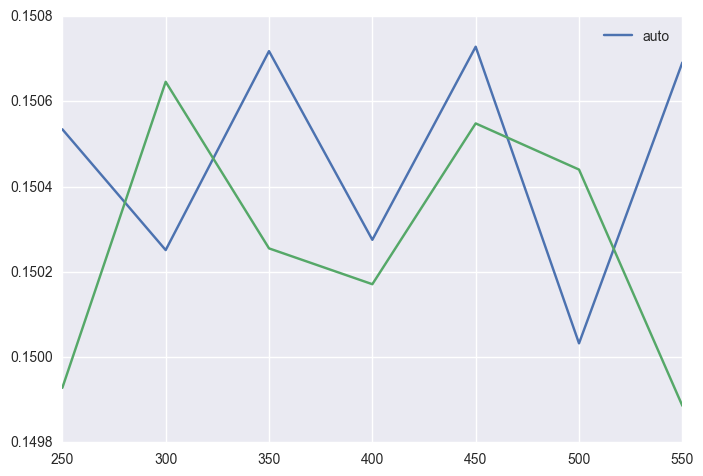

In [4]:
#RandomForestRegressor
est = [250,300,350,400,450,500,550]
feat = ["auto",None]
start = time.time()
rfr_params = {"n_estimators": est,
             "max_features": feat}
gs1 = GridSearchCV(rfr_model, rfr_params, scoring = simple_rmse)
gs1.fit(x,y)
end = time.time()
print end-start
print gs1.best_score_
print gs1.best_params_

for a,val in enumerate(feat):
    plt.plot(est,-gs1.cv_results_['mean_test_score'][len(est)*a:len(est)*(a+1)], label=val)
    plt.legend()
plt.show;


mean: 0.0106
standard deviation: 0.1388


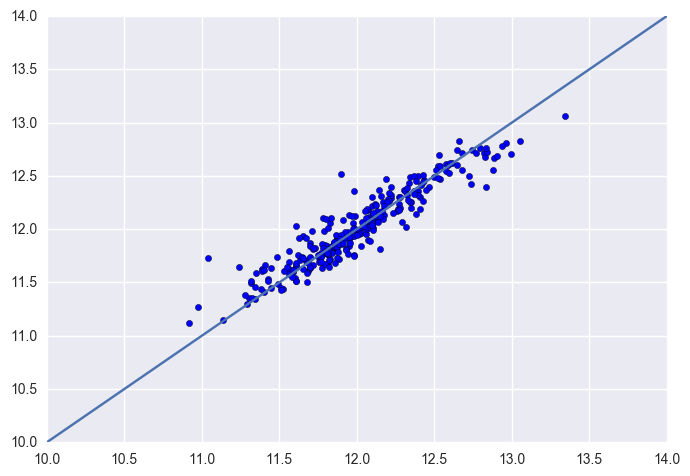

In [5]:
rfr_best = RFR(n_estimators =gs1.best_params_['n_estimators'],max_features =gs1.best_params_['max_features'])
plot_it(rfr_best)

142.68900013
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=None,
          max_features=None, max_leaf_nodes=None, min_impurity_split=1e-07,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=160, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)
-0.152571284939
{'max_features': None, 'n_estimators': 160, 'bootstrap': True, 'criterion': 'mse'}


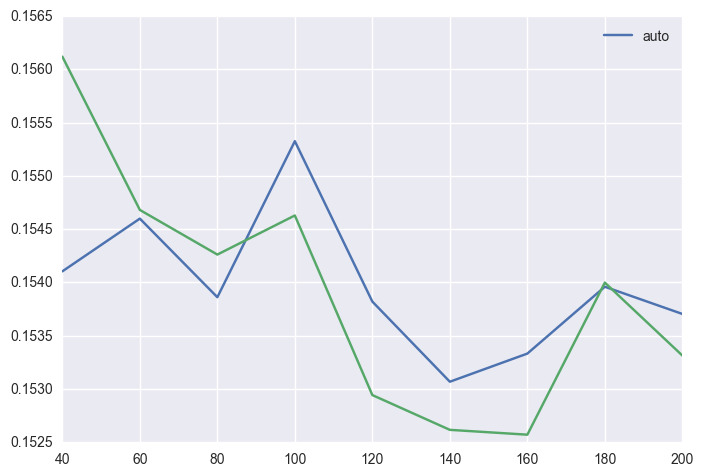

In [6]:
##ExtraTreesRegressor
est = [40,60,80,100,120,140,160,180,200]
feat = ["auto",None]
start = time.time()
etr_params = {"n_estimators": est,
             "max_features": feat,
             "criterion": ["mse"],
             "bootstrap": [True]}
gs2 = GridSearchCV(etr_model, etr_params, scoring = simple_rmse)
gs2.fit(x,y)
end = time.time()
print end-start
print gs2.best_estimator_
print gs2.best_score_
print gs2.best_params_

for a,val in enumerate(feat):
    plt.plot(est,-gs2.cv_results_['mean_test_score'][len(est)*a:len(est)*(a+1)], label=val)
    plt.legend()
plt.show;


mean: 0.0079
standard deviation: 0.1451


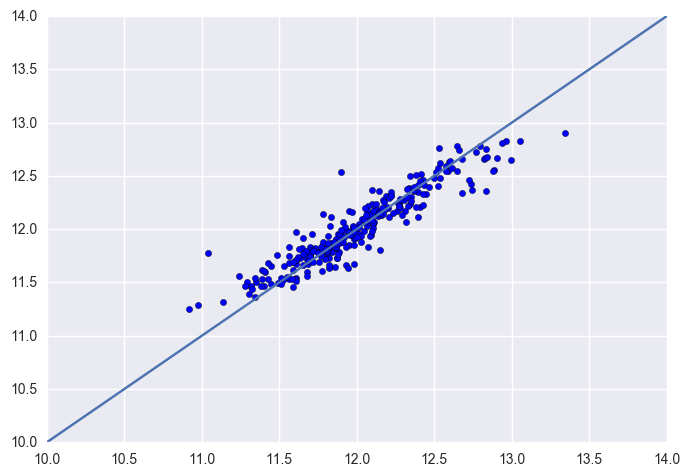

In [7]:
etr_best = ETR(n_estimators =gs2.best_params_['n_estimators'],max_features =gs2.best_params_['max_features'], criterion = "mse", bootstrap = True)
plot_it(etr_best)

229.189999819
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=400, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
-0.128651873057
{'max_features': 'auto', 'loss': 'ls', 'learning_rate': 0.1, 'n_estimators': 400, 'max_depth': 3}
[-0.13888707 -0.13711136 -0.1352272  -0.13355503 -0.1326049  -0.13366952
 -0.13208017 -0.1306323  -0.12985784 -0.1295188  -0.13470694 -0.13272711
 -0.1315263  -0.13085138 -0.12951778 -0.13104689 -0.13016353 -0.12908603
 -0.12877042 -0.1289369  -0.1348605  -0.13248936 -0.13061471 -0.13161378
 -0.13018624 -0.13122855 -0.13067227 -0.12942901 -0.12883902 -0.12865187
 -0.13168177 -0.1314827  -0.13238717 -0.13161652 -0.13080764 -0.13045488
 -0

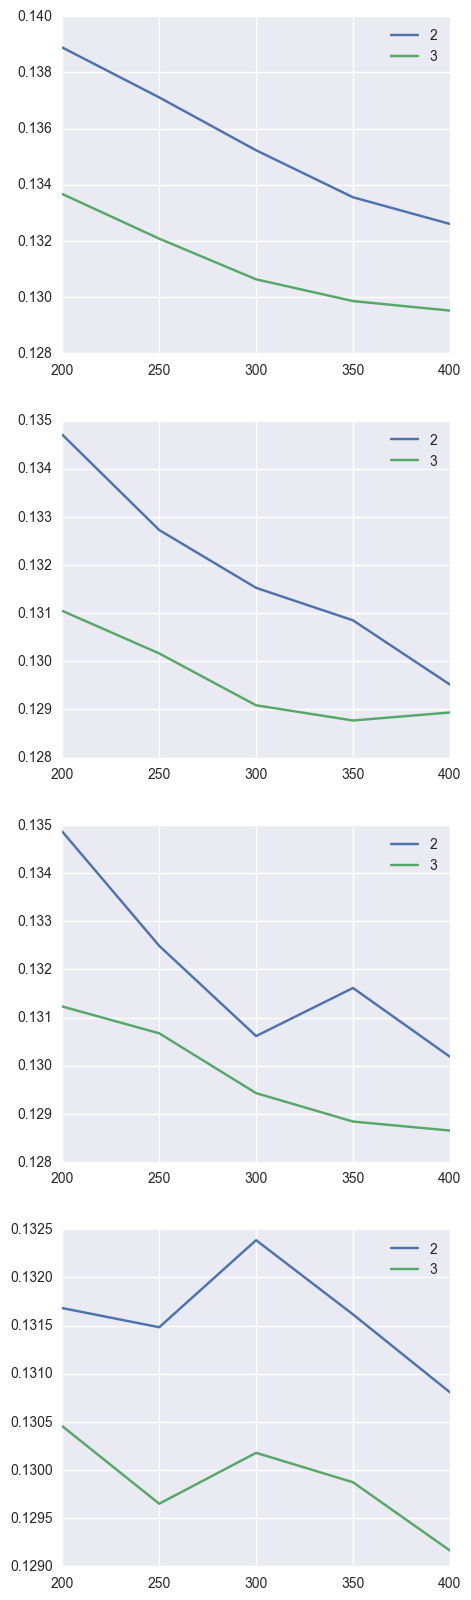

In [8]:
##GradientBoostingRegressor
est = [200,250,300,350,400]
md = [2,3]
lr = [.05, .075, .1, .15]
start = time.time()
gbr_params = {"n_estimators": est,
             "max_features": ["auto"],
             "max_depth": md,
             "learning_rate": lr,
             "loss": ["ls"]}#,"ls", "lad", "huber"]}
gs3 = GridSearchCV(gbr_model, gbr_params, scoring = simple_rmse)
gs3.fit(x,y)
end = time.time()
print end-start
print gs3.best_estimator_
print gs3.best_score_
print gs3.best_params_
print gs3.cv_results_['mean_test_score']

f, axarr = plt.subplots(len(lr))
for b,val2 in enumerate(lr):
    for a,val in enumerate(md):
        axarr[b].plot(est,-gs3.cv_results_['mean_test_score'][(len(est)*a)+(len(est)*len(md))*b:(len(est)*(a+1))+(len(est)*len(md))*b], label=val)
        axarr[b].legend()
        
f.set_figheight(5 * len(lr))
f.set_figwidth(5)
f.show;


mean: 0.0102
standard deviation: 0.1225


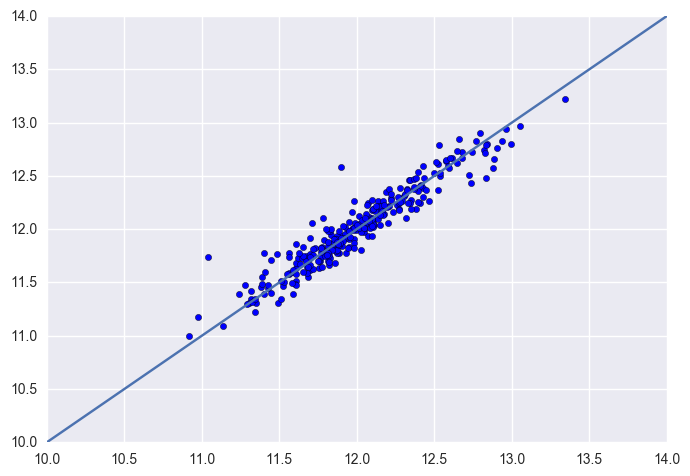

In [9]:
ls_gbr_best = GBR(n_estimators =gs3.best_params_['n_estimators'],max_features =gs3.best_params_['max_features'], max_depth =gs3.best_params_['max_depth'], learning_rate =gs3.best_params_['learning_rate'], loss=gs3.best_params_['loss'])
plot_it(ls_gbr_best)

772.0
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=4,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=400, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
-0.129755120609
{'max_features': 'auto', 'loss': 'lad', 'learning_rate': 0.1, 'n_estimators': 400, 'max_depth': 4}
[-0.14138396 -0.13820547 -0.13563019 -0.13444551 -0.13588448 -0.1384836
 -0.13551726 -0.13607001 -0.13349258 -0.13261053 -0.13755746 -0.13449876
 -0.13555121 -0.13439692 -0.13250919 -0.13652958 -0.13571966 -0.13423079
 -0.13297946 -0.13171245 -0.13555735 -0.13365173 -0.13251717 -0.13356651
 -0.13218125 -0.13361898 -0.13393469 -0.13306589 -0.13202071 -0.13243901
 -0.13492822 -0.13495377 -0.1344191  -0.13105656 -0.13231258 -0.1350311
 -0.1341169

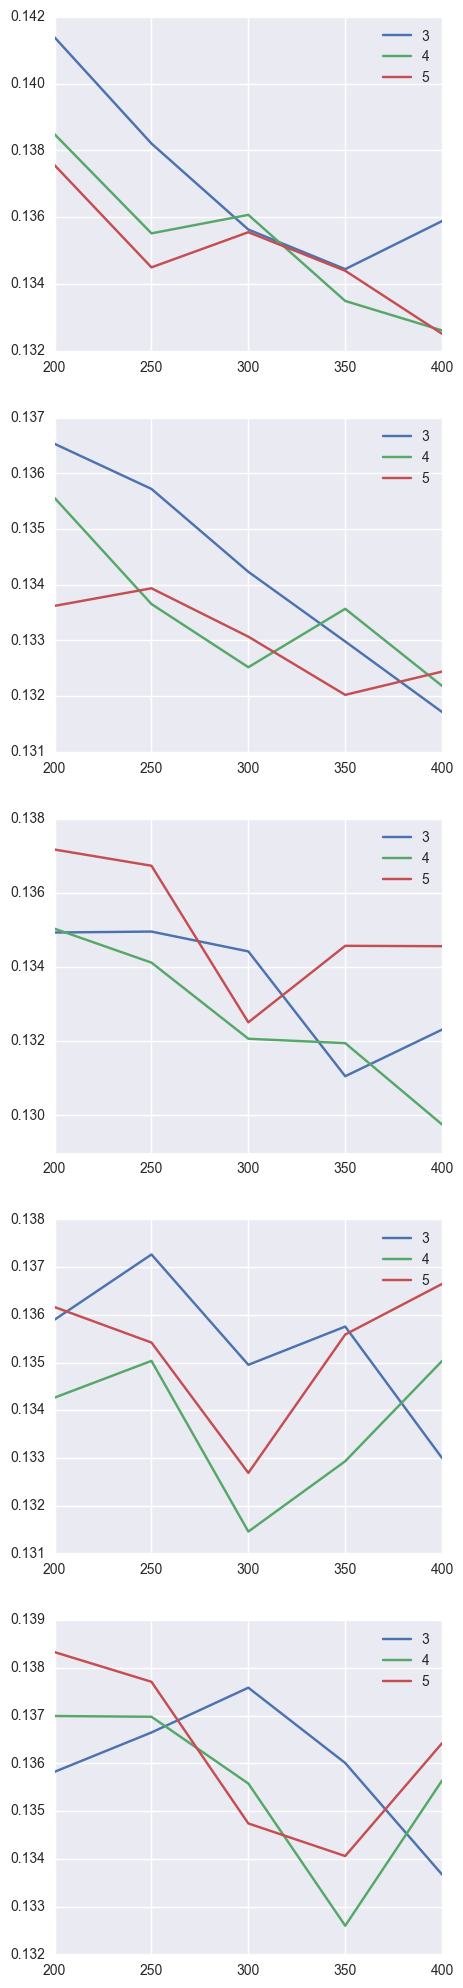

In [10]:
##GradientBoostingRegressor
est = [200,250,300,350,400]
md = [3,4,5]
lr = [.05, .075, .1, .15,.2]
start = time.time()
gbr_params = {"n_estimators": est,
             "max_features": ["auto"],
             "max_depth": md,
             "learning_rate": lr,
             "loss": ["lad"]}#,"ls", "lad", "huber"]}
gs3b = GridSearchCV(gbr_model, gbr_params, scoring = simple_rmse)
gs3b.fit(x,y)
end = time.time()
print end-start
print gs3b.best_estimator_
print gs3b.best_score_
print gs3b.best_params_
print gs3b.cv_results_['mean_test_score']

f, axarr = plt.subplots(len(lr))
for b,val2 in enumerate(lr):
    for a,val in enumerate(md):
        axarr[b].plot(est,-gs3b.cv_results_['mean_test_score'][(len(est)*a)+(len(est)*len(md))*b:(len(est)*(a+1))+(len(est)*len(md))*b], label=val)
        axarr[b].legend()
        
f.set_figheight(5 * len(lr))
f.set_figwidth(5)
f.show;


mean: 0.0160
standard deviation: 0.1273


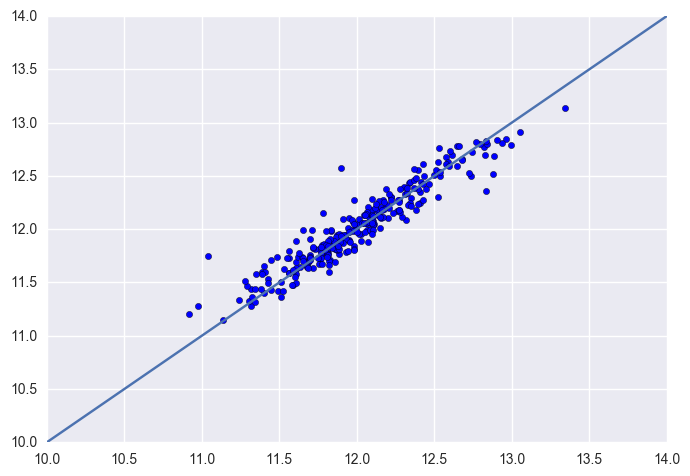

In [11]:
lad_gbr_best = GBR(n_estimators =gs3b.best_params_['n_estimators'],max_features =gs3b.best_params_['max_features'], max_depth =gs3b.best_params_['max_depth'], learning_rate =gs3b.best_params_['learning_rate'], loss=gs3b.best_params_['loss'])
plot_it(lad_gbr_best)

277.202000141
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.15, loss='huber', max_depth=3,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=250, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
-0.127910084638
{'max_features': 'auto', 'loss': 'huber', 'learning_rate': 0.15, 'n_estimators': 250, 'max_depth': 3}
[-0.14635055 -0.13940652 -0.13565076 -0.13357659 -0.13181857 -0.13163636
 -0.13230994 -0.13134343 -0.13034996 -0.13837807 -0.133862   -0.1316641
 -0.13120971 -0.13105348 -0.13075086 -0.13036618 -0.1296426  -0.12942382
 -0.13618458 -0.1338867  -0.13377588 -0.13188771 -0.13300853 -0.13292652
 -0.13272598 -0.13144285 -0.13204055 -0.12984302 -0.12944545 -0.12814607
 -0.12791008 -0.12879894 -0.12928507 -0.12955527 -0.12791301 -0.13012

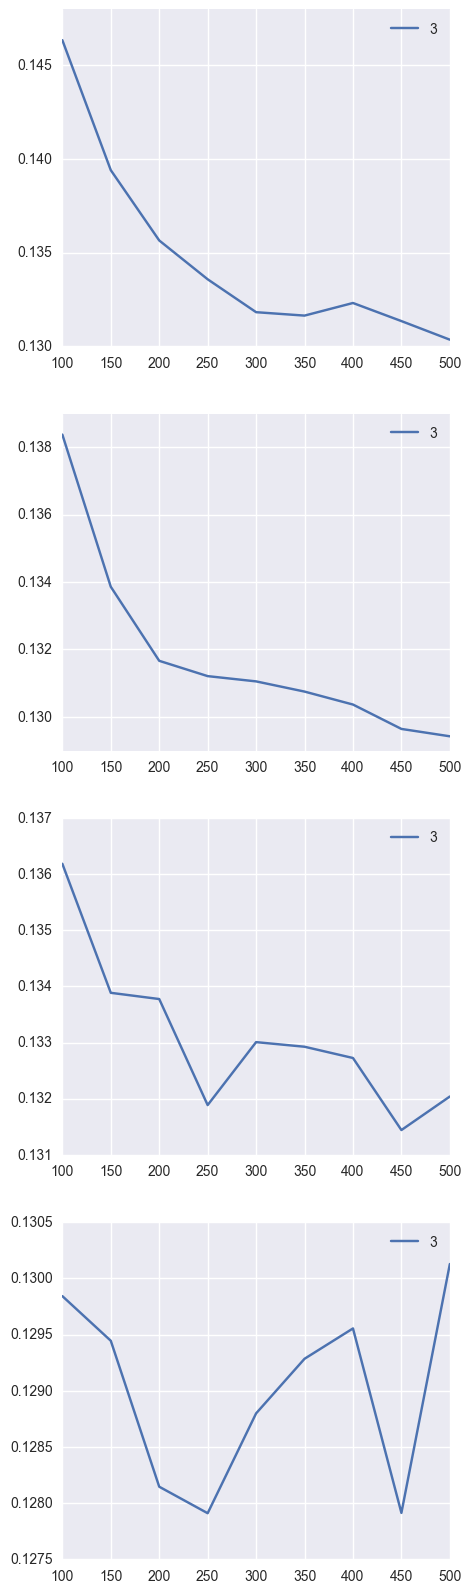

In [12]:
##GradientBoostingRegressor
est = [100,150,200,250,300,350,400, 450, 500]
md = [3]
lr = [.05, .075, .1, .15]
start = time.time()
gbr_params = {"n_estimators": est,
             "max_features": ["auto"],
             "max_depth": md,
             "learning_rate": lr,
             "loss": ["huber"]}#,"ls", "lad", "huber"]}
gs3c = GridSearchCV(gbr_model, gbr_params, scoring = simple_rmse)
gs3c.fit(x,y)
end = time.time()
print end-start
print gs3c.best_estimator_
print gs3c.best_score_
print gs3c.best_params_
print gs3c.cv_results_['mean_test_score']

f, axarr = plt.subplots(len(lr))
for b,val2 in enumerate(lr):
    for a,val in enumerate(md):
        axarr[b].plot(est,-gs3c.cv_results_['mean_test_score'][(len(est)*a)+(len(est)*len(md))*b:(len(est)*(a+1))+(len(est)*len(md))*b], label=val)
        axarr[b].legend()
        
f.set_figheight(5 * len(lr))
f.set_figwidth(5)
f.show;



mean: 0.0179
standard deviation: 0.1265


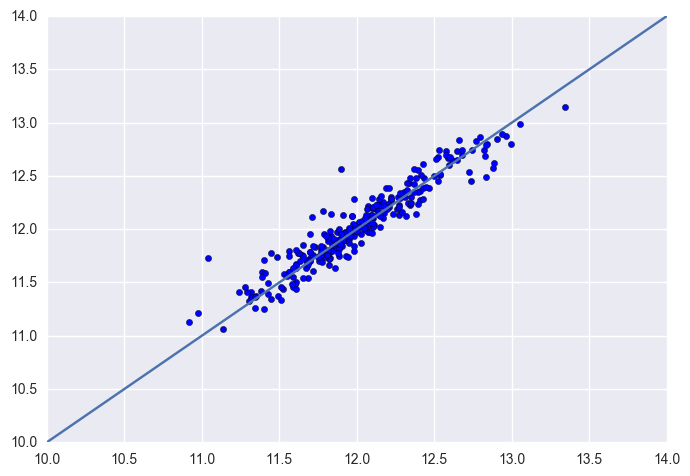

In [13]:
huber_gbr_best = GBR(n_estimators =gs3c.best_params_['n_estimators'],max_features =gs3c.best_params_['max_features'], max_depth =gs3c.best_params_['max_depth'], learning_rate =gs3c.best_params_['learning_rate'], loss=gs3c.best_params_['loss'])
plot_it(huber_gbr_best)

17.5750000477
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=15, p=2,
          weights='distance')
-0.305352144549
{'n_neighbors': 15, 'weights': 'distance'}


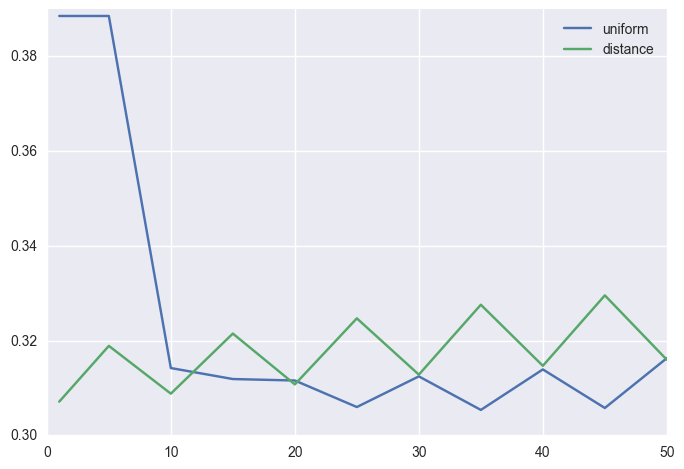

In [14]:
##KNeighborsRegressor
##ripe for feature reduction
n = [1,5,10,15,20,25,30,35,40,45,50]
w = ["uniform", "distance"]

start = time.time()
knr_params = {"n_neighbors": n,
             "weights": w}
gs4 = GridSearchCV(knr_model, knr_params, scoring = simple_rmse)
gs4.fit(x,y)
end = time.time()
print end-start
print gs4.best_estimator_
print gs4.best_score_
print gs4.best_params_

for a,val in enumerate(w):
    plt.plot(n,-gs4.cv_results_['mean_test_score'][len(n)*a:len(n)*(a+1)], label=val)
    plt.legend()
plt.show;


mean: -0.0144
standard deviation: 0.3044


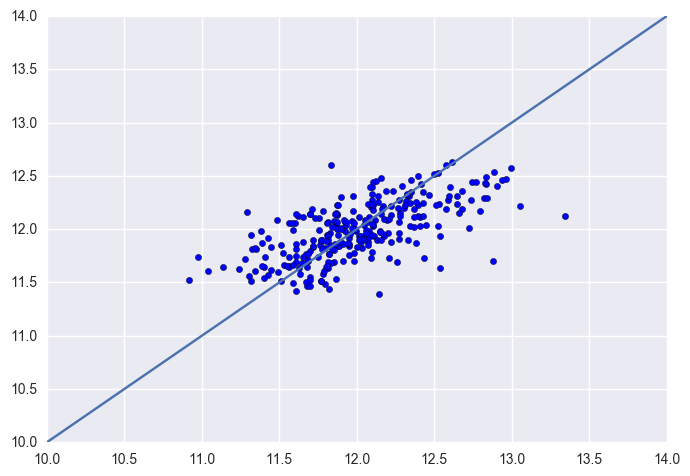

In [15]:
knr_best = KNR(n_neighbors = gs4.best_params_['n_neighbors'], weights = gs4.best_params_['weights'])
plot_it(knr_best)

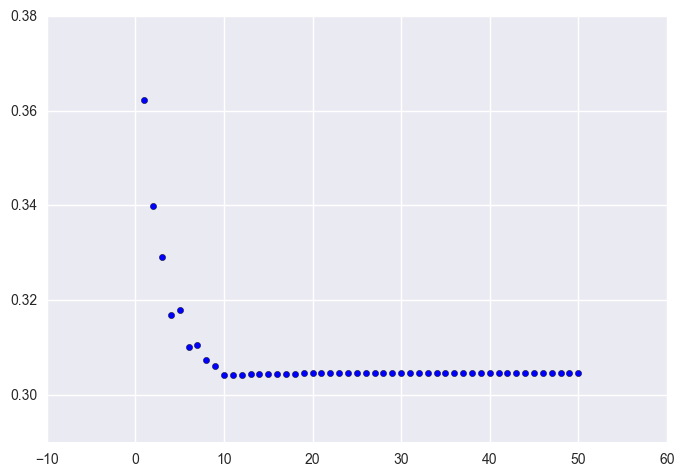

In [16]:
plot_pca(knr_best, 50)

7.48300004005
DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')
-0.211351666485
{'max_features': None, 'criterion': 'mse'}
[-0.21532619 -0.21135167 -0.28136544 -0.24859705 -0.24874222 -0.23517838
 -0.23175189 -0.23731135 -0.28321713 -0.24502385 -0.2435731  -0.24603362]
mean: 0.0177
standard deviation: 0.2049


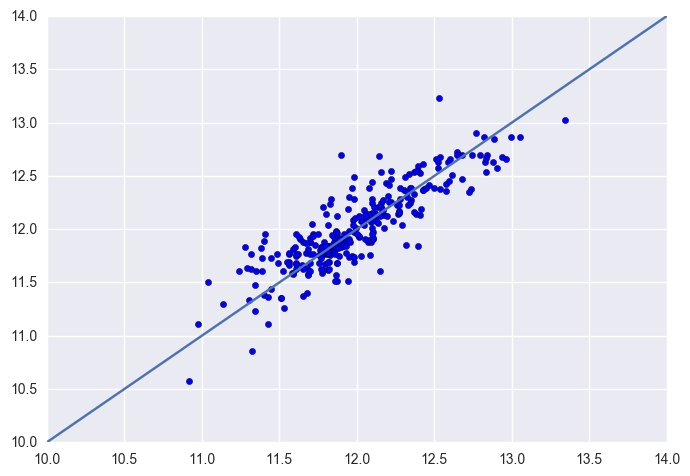

In [ ]:
##DecisionTreeRegressor
start = time.time()
dtr_params = {"max_features": ["auto",None, 10, 30, 50, 100],
             "criterion": ["mse", "mae"]}
gs5 = GridSearchCV(dtr_model, dtr_params, scoring = simple_rmse)
gs5.fit(x,y)
end = time.time()
print end-start
print gs5.best_estimator_
print gs5.best_score_
print gs5.best_params_
print gs5.cv_results_['mean_test_score']

dtr_best = DTR(max_features = gs5.best_params_['max_features'], criterion = 'mse')
plot_it(dtr_best)

In [ ]:
##linear svr
##feature reduction
start = time.time()
c = [.001,.01,.1,1,10,100]
lsvr_params = {"C": c}
gs6 = GridSearchCV(lsvr_model, lsvr_params, scoring = simple_rmse)
gs6.fit(x,y)
end = time.time()
print end-start
print gs6.best_estimator_
print gs6.best_score_
print gs6.best_params_

plt.plot(c, gs6.cv_results_['mean_test_score'])


In [ ]:
lsvr_best = SVR(kernel = 'linear', c = gs6.best_params_['C'])
plot_it(lsvr_best)

In [ ]:
##poly svr
##feature reduction
c = [.001,.01,.1,1,10,100]
d = [1,2,3]
start = time.time()
psvr_params = {"C": c,
              "degree": d}
gs7 = GridSearchCV(psvr_model, psvr_params, scoring = simple_rmse)
gs7.fit(x,y)
end = time.time()
print end-start
print gs7.best_estimator_
print gs7.best_score_
print gs7.best_params_

for a,val in enumerate(d):
    plt.plot(c,-gs7.cv_results_['mean_test_score'][len(c)*a:len(c)*(a+1)], label=val)
    plt.legend()
plt.show;


In [ ]:
psvr_best = SVR(kernel = 'poly', c = gs7.best_params_['C'], degree = gs7.best_params_['degree'])
plot_it(psvr_best)

In [ ]:
##rbf svr
##feature reduction
c = [.001,.01,.1,1,10,100]
start = time.time()
rsvr_params = {"C": c}
gs8 = GridSearchCV(rsvr_model, rsvr_params, scoring = simple_rmse)
gs8.fit(x,y)
end = time.time()
print end-start
print gs8.best_estimator_
print gs8.best_score_
print gs8.best_params_

plt.plot(c, -gs8.cv_results_['mean_test_score'])


In [ ]:
rsvr_best = SVR(kernel = 'rbf', c = gs8.best_params_['C'])
plot_it(rsvr_best)

In [ ]:
##passive aggressive regression
##feature reduction
c = [.01,.05, .1,.25,.5,1]
start = time.time()
par_params = {"C": c}
gs9 = GridSearchCV(par_model, par_params, scoring = simple_rmse)
gs9.fit(x,y)
end = time.time()
print end-start
print gs9.best_estimator_
print gs9.best_score_
print gs9.best_params_
print gs9.cv_results_['mean_test_score']

plt.plot(c, -gs9.cv_results_['mean_test_score']);


In [ ]:
par_best = PAR(c = gs9.best_params_['C'])
plot_it(par_best)

In [ ]:
##linear kernel ridge
##feature reduction
a = [.001,.01,.1,1,10]
start = time.time()
lkr_params = {"alpha": a}
gs10 = GridSearchCV(lkr_model, lkr_params, scoring = simple_rmse)
gs10.fit(x,y)
end = time.time()
print end-start
print gs10.best_estimator_
print gs10.best_score_
print gs10.best_params_

plt.plot(a, -gs10.cv_results_['mean_test_score'])


In [ ]:
lkr_best = KR(kernel = 'linear', alpha = gs10.best_params_['alpha'])
plot_it(lkr_best)

In [ ]:
##poly kernel ridge
##feature reduction
a = [.001,.01,.1,1,10]
d = [1,2,3]
start = time.time()
pkr_params = {"alpha": a,
              "degree": d}
gs11 = GridSearchCV(pkr_model, pkr_params, scoring = simple_rmse)
gs11.fit(x,y)
end = time.time()
print end-start
print gs11.best_estimator_
print gs11.best_score_
print gs11.best_params_

for b,val in enumerate(d):
    plt.plot(a,-gs11.cv_results_['mean_test_score'][len(a)*b:len(a)*(b+1)], label=val)
    plt.legend()
plt.show;


In [ ]:
pkr_best = KR(kernel = 'poly', alpha = gs11.best_params_['alpha'], degree = gs11.best_params_['degree'])
plot_it(pkr_best)

In [ ]:
##rbf kernel ridge
##feature reduction
a = [.001,.01,.1,1,10,100]
start = time.time()
rkr_params = {"alpha": a
gs12 = GridSearchCV(rkr_model, rkr_params, scoring = simple_rmse)
gs12.fit(x,y)
end = time.time()
print end-start
print gs12.best_estimator_
print gs12.best_score_
print gs12.best_params_

plt.plot(a, -gs12.cv_results_['mean_test_score'])
              

In [ ]:
rkr_best = KR(kernel = 'rbf', alpha = gs12.best_params_['alpha'])
plot_it(rkr_best)

In [ ]:
##GaussianProcessRegressor
##feature reduction
start = time.time()
print rmse_cv(gpr_model, x, y)
print simple_rmse(gpr_model, x, y)
end = time.time()
print end-start
#print sorted(gs9.cv_results_.keys())

plot_it(gpr_model)